In [1]:
# WHICH METRIC IS MOST IMPORTANT FOR THIS TASK
# In this case, it is important to identify all the people that, based on their features, are likely to subscribe a bank deposit.
# Once they are identified, they can be contacted by the marketing agents, and the probability they will say "yes" will be high.
# For this reason, it is important they are identified by the model --> we want high recall.
# If the model fails and says a customer is a "yes" while in reality they are a "no", it will be a waste of time by the bank.
# However, if their number is reasonably low, the bank would probably be happier to hear a "no" than to miss a potential new subscriber.
# This means that we want high recall, while the precision is not so important (it is, because we don't want to phone to all the 
# customers, but calling some "no" customers is a waste of time the bank would bear, I suppose).

In [2]:
import pandas as pd
import sklearn.metrics
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.ensemble
from collections import Counter
import numpy as np
import imblearn
import random
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('data/ohe_df.csv')
df.shape

(45210, 35)

# <ins> SCALING

In [4]:
features_to_scale = [feat for feat in df.columns if len(df[feat].value_counts()) > 2]
features_to_scale

['age', 'balance', 'previous']

In [5]:
# Instantiate scaler
scaler = sklearn.preprocessing.StandardScaler()

In [6]:
# Fit scaler on just the continuous features (do not scale one-hot features!) and transform
scaler.fit(df[features_to_scale])
scaled_array = scaler.transform(df[features_to_scale])
df[features_to_scale] = scaled_array

# <ins> SPLIT

In [7]:
train_perc = 0.70
val_perc = 0.20
test_perc = 0.10

In [8]:
X_train_val = df.drop(columns='y')
y_train_val = df['y']

In [9]:
X_train_val, X_test, y_train_val, y_test = sklearn.model_selection.train_test_split(
    X_train_val,
    y_train_val,
    test_size=test_perc,
    stratify=y_train_val,
    random_state=42
)

X_train_val.shape, X_test.shape

((40689, 34), (4521, 34))

In [10]:
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(
    X_train_val,
    y_train_val,
    test_size=val_perc/(1-test_perc),
    stratify=y_train_val,
    random_state=42
)

X_train.shape, X_val.shape

((31647, 34), (9042, 34))

In [11]:
X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == df.shape[0] 

True

# <ins> RESAMPLING

In [12]:
# To be done after the splitting, because downsampling (or upsampling) change the distribution of 0s and 1s in the training set, 
# but they should not change the distribution in the validation or test set because these should reflect the real world distribution.

## DOWNSAMPLING

In [13]:
# Downsample the majority class

In [14]:
idxs_target_1 = y_train[y_train == 1].index.tolist()
idxs_target_0 = y_train[y_train == 0].index.tolist()

len(idxs_target_1), len(idxs_target_0)

(3702, 27945)

In [15]:
n_downsampling = int(len(idxs_target_1) * 1)

random.seed(42)
idxs_target_0_to_keep = random.sample(idxs_target_0, n_downsampling)

In [16]:
idxs = list(set(idxs_target_1) | set(idxs_target_0_to_keep))

len(idxs)

7404

In [17]:
X_train = X_train.loc[idxs].reset_index(drop=True)
y_train = y_train.loc[idxs]

X_train.shape, y_train.shape

((7404, 34), (7404,))

## UPSAMPLING

In [138]:
# Upsample the minority class
# actually, here I'll upsample the minority class (adding duplicates) and 
# downsample the majority class to make a balanced dataset

In [12]:
idxs_target_1 = y_train[y_train == 1].index.tolist()
idxs_target_0 = y_train[y_train == 0].index.tolist()

len(idxs_target_1), len(idxs_target_0)

(3702, 27945)

In [13]:
upsampling_perc = 2

In [14]:
n_to_upsample_target_1 = int(len(idxs_target_1) * upsampling_perc)

random.seed(42)
upsampled_idxs_target_1 = random.choices(population=idxs_target_1, k=n_to_upsample_target_1)

len(upsampled_idxs_target_1)

7404

In [15]:
final_idxs_target_1 = idxs_target_1 + upsampled_idxs_target_1

len(final_idxs_target_1)

11106

In [16]:
# Downsampling
random.seed(42)
idxs_target_0_to_keep = random.sample(idxs_target_0, len(final_idxs_target_1))

len(idxs_target_0_to_keep)

11106

In [17]:
idxs = final_idxs_target_1 + idxs_target_0_to_keep

len(idxs)

22212

In [18]:
X_train = X_train.loc[idxs].reset_index(drop=True)
y_train = y_train.loc[idxs]

X_train.shape, y_train.shape

((22212, 34), (22212,))

## SMOTE

In [12]:
# - SMOTE will balance the dataset by creating synthetic data with class 1 via KNN.
# - To avoid a too high proportion of synthetic data, class 0 is first downsampled
#   to N, where N is the number of samples per class I'll want in the final dataset.
# - This is here expressed as a multiple of the number of instances of class 1 in 
#   the original dataset.

In [13]:
idxs_target_1 = y_train[y_train == 1].index.tolist()
idxs_target_0 = y_train[y_train == 0].index.tolist()

In [14]:
n_downsampling = len(idxs_target_1) * 2

random.seed(42)
idxs_target_0_to_keep = random.sample(idxs_target_0, n_downsampling)
print(len(idxs_target_1), len(idxs_target_0_to_keep))

idxs = list(set(idxs_target_1) | set(idxs_target_0_to_keep))
X_train = X_train.loc[idxs].reset_index(drop=True)
y_train = y_train.loc[idxs]

X_train.shape, y_train.shape

3702 11106


((14808, 34), (14808,))

In [15]:
smote = imblearn.over_sampling.SMOTE(
    sampling_strategy='minority', # resample only the minority class
    k_neighbors=5, 
    random_state=42
)

X_train, y_train = smote.fit_resample(X_train, y_train)

X_train.shape, y_train.shape

((22212, 34), (22212,))

# <ins> RANDOM FOREST

In [19]:
rf_model = sklearn.ensemble.RandomForestClassifier(
    n_estimators=200,
    criterion='gini',
    max_depth=None, # None = max depth possible
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=None,
    bootstrap=True,
    n_jobs=12,
    random_state=42,
    class_weight=None # 'balanced_subsample' for unbalanced data
)

# Effect of using class weights for unbalanced data:
# - in boostrapping the instances for each tree, to ensure adeguate representation of the rare class (specific for `balanced_subsample`).
# - changes Gini index and therefore features to split upon.

In [20]:
_ = rf_model.fit(X=X_train, y=y_train)

In [21]:
y_pred = rf_model.predict(X_val)

In [22]:
tp = ((y_val == 1) * (y_pred == 1)).sum()
tn = ((y_val == 0) * (y_pred == 0)).sum()
fp = ((y_val == 0) * (y_pred == 1)).sum()
fn = ((y_val == 1) * (y_pred == 0)).sum()

tp, tn, fp, fn

(463, 6829, 1155, 595)

In [23]:
# # Confusion matrix
# sklearn.metrics.confusion_matrix(y_true=y_val, y_pred=y_pred)

In [24]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)

probs = rf_model.predict_proba(X_val)[:, 1]
auc = sklearn.metrics.roc_auc_score(y_val, probs)

metrics = np.array([accuracy, precision, recall, specificity, auc]).round(2).tolist()
print(metrics)

metrics_df = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'specificity', 'auc'])
metrics_df.loc[0] = metrics
metrics_df.to_csv('metrics.csv', index=False)

[0.81, 0.29, 0.44, 0.86, 0.7]


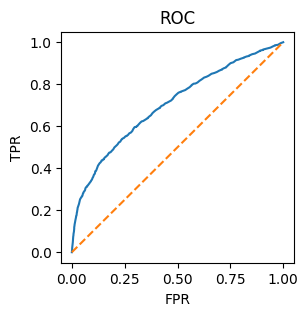

In [25]:
# ROC
fpr, tpr, _ = sklearn.metrics.roc_curve(y_val, probs)

plt.figure(figsize=(3, 3))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()

In [26]:
# With a perfectly balanced dataset, the model identifies 62% of the probable "yes" customers (recall = 0.624),
# and the marketing agents will get a "yes" answer every 5 calls (precision = 0.206).

## FEATURE IMPORTANCE

In [27]:
feature_importances = rf_model.feature_importances_.round(3)
feature_importances

array([0.206, 0.35 , 0.005, 0.004, 0.012, 0.016, 0.014, 0.033, 0.017,
       0.017, 0.009, 0.007, 0.018, 0.005, 0.009, 0.014, 0.005, 0.019,
       0.008, 0.022, 0.011, 0.015, 0.01 , 0.019, 0.015, 0.006, 0.006,
       0.005, 0.004, 0.006, 0.004, 0.077, 0.004, 0.027])

In [28]:
feat_imp_dict = dict(zip(feature_importances, X_train.columns))

In [29]:
sorted(feat_imp_dict.items(), key=lambda x:x[0], reverse=True)[:20]

[(0.35, 'balance'),
 (0.206, 'age'),
 (0.077, 'poutcome_success'),
 (0.033, 'housing'),
 (0.027, 'previous'),
 (0.022, 'loan'),
 (0.019, 'n_contacts_1'),
 (0.018, 'job_management'),
 (0.017, 'job_blue-collar'),
 (0.016, 'education_secondary'),
 (0.015, 'n_contacts_2-8'),
 (0.014, 'job_services'),
 (0.012, 'education_primary'),
 (0.011, 'marital_divorced'),
 (0.01, 'marital_single'),
 (0.009, 'job_self-employed'),
 (0.008, 'job_unemployed'),
 (0.007, 'job_housemaid'),
 (0.006, 'pdays_never_contacted_before'),
 (0.005, 'pdays_201-400')]

## CROSS-VALIDATION

In [30]:
X_crossval = pd.concat([X_train, X_val]).reset_index(drop=True) # GETS RESAMPLED
y_crossval = pd.concat([y_train, y_val]).reset_index(drop=True) # GETS NOT RESAMPLED! FIX! REDO METRICS!

X_crossval.shape, y_crossval.shape

((31254, 34), (31254,))

In [31]:
rf_model = sklearn.ensemble.RandomForestClassifier(
    n_estimators=200,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=None,
    bootstrap=True,
    n_jobs=12,
    random_state=42,
    class_weight=None
)

In [32]:
cv_scores = sklearn.model_selection.cross_val_score(
    estimator=rf_model, 
    X=X_crossval, 
    y=y_crossval,
    scoring='recall',
    cv=5, # For int/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. 
    n_jobs=12
)

cv_scores.mean().round(2)

0.91